# Drug-Seq 数据分析

## rawdata 预处理

使用 `drug_seq_v2.py` 脚本，对 fastq 文件进行预处理

In [ ]:
#drug seq data preprocess
import os
import sys


import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import gzip
import pysam


######################################################
##1. 读入fastq1，获取barcode、UMI
##2. 对数据进行质控与可视化
######################################################
def get_fastq1(barcode,fastq1):
    R1_reads={}
    with gzip.open(fastq1, 'rt') as f:
        for line in f:
            sequence_identifier = line.strip()  # 序列标识符，通常是 '@' 开头的行
            sequence_ID=re.sub(" [0-9]*\\/[0-9]*","",sequence_identifier)
            if sequence_identifier.startswith('@'):
                sequence = next(f).strip()  # 序列行
                barcode_id=sequence[:10]
                UMI=sequence[-10:]
                _ = next(f).strip()
                quality_scores = next(f).strip()  # 质量分数行
                R1_reads[sequence_ID]=barcode_id+"_"+UMI

    barcodes=get_barcode_library(barcode)
    rs={} #用于存储解析后的barcode_UMI，仅限有效的barcodes
    for k,v in R1_reads.items():
        r1=re.sub("\\_.*","",v)
        if r1 in barcodes:
            r2=re.sub(".*\\_(.*)","\\1",v)
            if r1 in rs:
                if r2 in rs[r1]:
                    rs[r1][r2] +=1
                else:
                    rs[r1][r2]=1
            else:
                rs[r1]={r2:1}

    #每个barcode下的UMI，转录本数目
    barcode_umi_library_size={}
    for k,v in rs.items():
        barcode_umi_library_size[k]=len(v)        
    df=pd.DataFrame.from_dict(barcode_umi_library_size, orient='index')
    df.columns=['N']
    df.to_csv("UMI_counts_in_Barcodes.csv")

    plt.hist(df[['N']], bins=30, edgecolor='black')  # bins参数控制直方图的条形数，edgecolor设置条形边缘颜色
    plt.title('N of transcripts in 360 wells')# 添加标题和标签
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.savefig("UMI_counts_distribution.png")# 显示直方图
    plt.close()


    #每个wells中，UMI>1的转录本个数
    barcode_umi_dupliates={}
    for k,v in rs.items():
        barcode_umi_dupliates[k]=sum(1 for value in v.values() if value > 1)/len(v)
    df=pd.DataFrame.from_dict(barcode_umi_dupliates, orient='index')
    df.columns=['Rate']
    df.to_csv("UMI_duplicates.csv")
    
    plt.hist(df[['Rate']], bins=30, edgecolor='black')  # bins参数控制直方图的条形数，edgecolor设置条形边缘颜色
    plt.title('UMI duplicate rates')# 添加标题和标签
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.savefig("UMI_duplicates.png")# 显示直方图
    plt.close()
    
    return(R1_reads)


######################################################
##获取有效barcode，减少不必要的检索
##
######################################################
def get_barcode_library(barcode):
    barcode_id=pd.read_csv(barcode)
    barcodes=list(barcode_id['barcode_ID'])
    return barcodes

######################################################
##将fastq2比对到参考基因组
##
######################################################
def align_to_reference(sample,fastq2):
    _cmd={}
    _cmd['STAR']= '''/OIU/sge_software/STAR/STAR-2.4.2a/bin/Linux_x86_64/STAR \
        --genomeDir /OIU/database_NGS/hg38/reference/STAR_242a_index \
        --sjdbGTFfile /OIU/database_NGS/hg38/GTF/gencode.v45.primary_assembly.annotation.gtf \
        --limitBAMsortRAM 40000000000 \
        --runThreadN 4 \
        --limitIObufferSize 500000000 \
        --outFilterType BySJout \
        --outFilterMismatchNmax 999 \
        --outFilterMismatchNoverLmax 0.04 \
        --outFilterMultimapNmax 20 \
        --outFilterMatchNminOverLread 0.66 \
        --outFilterIntronMotifs None \
        --outSJfilterReads All \
        --outSAMtype BAM SortedByCoordinate \
        --outSAMunmapped Within \
        --outSAMstrandField intronMotif \
        --outSAMattrRGline ID:{prefix} SM:{prefix} PL:ILLUMINA \
        --alignSJoverhangMin 8 \
        --alignSJDBoverhangMin 1 \
        --alignIntronMin 20 \
        --alignIntronMax 1000000 \
        --alignMatesGapMax 1000000 \
        --chimSegmentMin 15 \
        --chimJunctionOverhangMin 15 \
        --chimScoreMin 0 \
        --chimScoreDropMax 20 \
        --chimScoreSeparation 10 \
        --chimScoreJunctionNonGTAG -1 \
        --quantMode TranscriptomeSAM \
        --quantTranscriptomeBan IndelSoftclipSingleend \
        --outReadsUnmapped Fastx \
        --readFilesIn  {R2} \
        --readFilesCommand zcat \
        --outFileNamePrefix  {prefix}.'''.format(prefix=sample,R2=fastq2)
        
    _cmd['sort']='''/OIU/sge_software/samtools/currentVersion/samtools sort {prefix}.Aligned.toTranscriptome.out.bam > {prefix}.Aligned.toTranscriptome.out_sort.bam'''.format(prefix=sample)
    _cmd['index']='''/OIU/sge_software/samtools/currentVersion/samtools index {prefix}.Aligned.toTranscriptome.out_sort.bam'''.format(prefix=sample)
    os.system(_cmd['STAR'])
    os.system(_cmd['sort'])
    os.system(_cmd['index'])


######################################################
##解析bam文件，获取reads和genes
##
######################################################
def get_reads_genes_from_BAM(sample):
    reads_genes={}#包括： reads-> genes
    with pysam.AlignmentFile("{}.Aligned.toTranscriptome.out_sort.bam".format(sample), "r") as bamfile:
        for read in bamfile.fetch():
            if not read.is_unmapped and read.query_name.startswith('SRR'):
                read_records=read.to_dict()
                if read_records['name'] in reads_genes:
                    reads_genes[read_records['name']].append(read_records['ref_name'])
                else:
                    reads_genes[read_records['name']]=[read_records['ref_name']]   

    return reads_genes

######################################################
##联合R1,R2分析结果，将readsID 置换为 barcode_ID 和 UMI
##
######################################################
def exchange_readsID_with_barcodeUMI(barcode,R1_reads,reads_genes):
    tmp={}
    barcodes=get_barcode_library(barcode)
    for k,v in reads_genes.items():
        r1=re.sub("\\_.*","",R1_reads["@"+k])
        if r1 in barcodes:#即为有效barcode
            if R1_reads["@"+k] in tmp:
                #print(tmp[R1_reads["@"+k]])
                tmp[R1_reads["@"+k]].update({g:np.round(1/len(v),2) for g in v})
                #print(tmp[R1_reads["@"+k]])
                #i +=1
                #print(i)#难道只是PCR重复带来的UMI重复？
                #print("--------------------------")
            else:
                tmp[R1_reads["@"+k]]={g:np.round(1/len(v),2) for g in v}
    return(tmp)

######################################################
##定量，在不同barcode中，定量转录本的表达
##
######################################################
def counts_UMI_for_transcripts_in_each_barcodes(tmp):
    barcode_expression={}
    for k,v in tmp.items():
        r1=re.sub("\\_.*","",k)#获取barcode 序列
        for g,c in v.items():
            if r1 in barcode_expression:
                if g in barcode_expression[r1]:
                    barcode_expression[r1][g] += c
                else:
                    barcode_expression[r1][g]=c
            else:
                barcode_expression[r1] = {g:c}   
    return barcode_expression


######################################################
##定量，在不同barcode中，定量基因水平的表达
##
######################################################
def counts_UMI_in_gene_level(transcripts_counts):
    barcode_genes={}
    gene_transcript=get_transciprts_genes_from_GTF()
    for barcode,transripts in transcripts_counts.items():
        barcode_genes[barcode]={}
        for transriptsID,counts in transripts.items():
            if gene_transcript[transriptsID] in barcode_genes[barcode]:
                barcode_genes[barcode][gene_transcript[transriptsID]] += np.round(counts,0) #不同基因转录本数据相加
            else:
                barcode_genes[barcode][gene_transcript[transriptsID]] = np.round(counts,0)  
    barcode_expression_df=pd.DataFrame.from_dict(barcode_genes)
    return barcode_expression_df

def get_transciprts_genes_from_GTF():
    GTF="/OIU/database_NGS/hg38/GTF/gencode.v45.primary_assembly.annotation.gtf"
    gene_transcript={}
    with open(GTF,"r") as f:
        fs=f.readlines()
        for rs in fs:
            if re.search("^chr",rs):
                records=re.split("\t",rs)
                if records[2]=="transcript":
                    gs=re.split(";",records[8])
                    gs_transcript_id=re.split("\s",gs[1])[2].strip('\\""')
                    gs_genesymbol=re.split("\s",gs[3])[2].strip('\\""')
                    gene_transcript[gs_transcript_id]=gs_genesymbol
    return gene_transcript

#计算信息
if __name__ == '__main__':
    if len(sys.argv) != 5:
        print("Usage: python drugseq.py barcode fastq1 fastq2 sample")
    else:
        barcode=sys.argv[1]
        fq1=sys.argv[2]
        fq2=sys.argv[3]
        sample=sys.argv[4]
        #step1
        R1_reads=get_fastq1(barcode, fq1) #barcode,fastq1
        #step2
        align_to_reference(sample, fq2) ##barcode,fastq2, 比对
        #step3
        reads_genes=get_reads_genes_from_BAM(sample)
        #step4
        tmp=exchange_readsID_with_barcodeUMI(barcode,R1_reads,reads_genes)
        transcripts_counts=counts_UMI_for_transcripts_in_each_barcodes(tmp)#转录本水平获取表达数据
        count_matrix=counts_UMI_in_gene_level(transcripts_counts)#基因水平获取表达数据
        count_matrix.to_csv(sample+"_count_matrix_gene_level.csv")

## matrix分析

1. 文章中matrix的分析

2. 复现文章中的上游数据处理

### 对一个样本进行drug-seq分析

主要有：

1. 聚类
2. 差异分析
3. 结果可视化等

In [2]:
setwd("D:\\Cell_panel_screening\\DRUG-Seq\\GSM5357044")
#360 wells, 5w+ genes
m=load("GSM5357044_flowcell_4000_UMI_decode_VH02001612.RData")

library(data.table)
library(dplyr)
library(ggplot2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



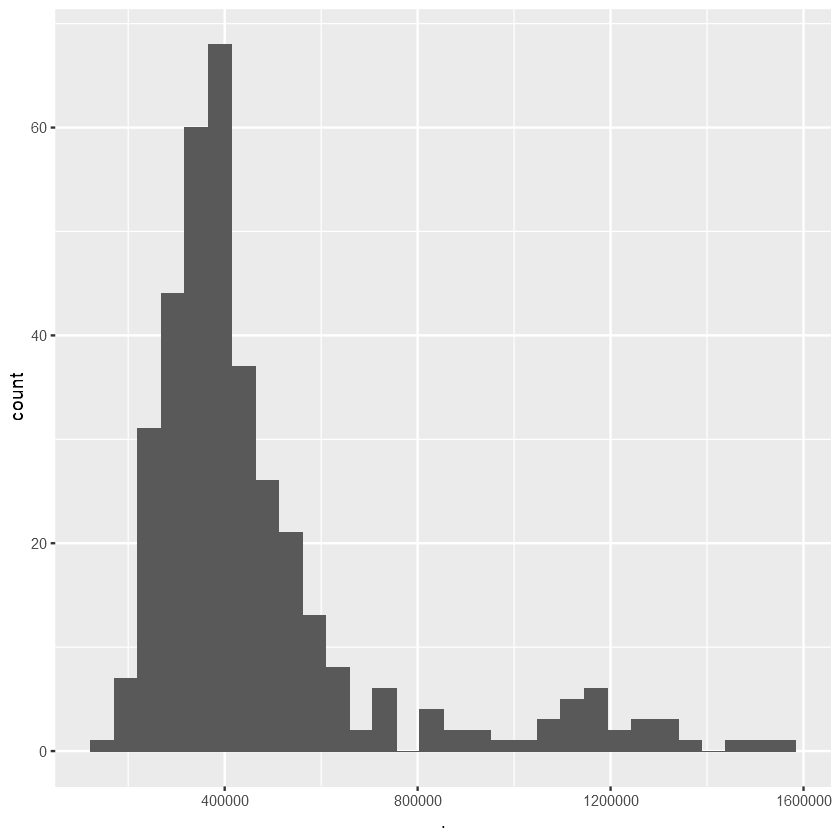

In [3]:
#各样本文库大小
colSums(UMI_decode) %>% 
  as.data.frame() %>% 
  ggplot(aes(x=.))+
  geom_histogram()

In [4]:
meta=fread("cb1c00920_si_001/File_S1_metadata.csv") %>% 
  filter(plate_barcode=="VH02001612")
#3个sectors，8个 dose，所以每个药物共有24例数据
meta %>% count(compound)

compound,n
<chr>,<int>
(S)-Crizotinib,24
AZD8055,24
BLU9931,24
Brusatol,24
BTdCPU,24
CHIR118637,24
Cmp_334,24
Cmp_341,24
CPI-203,24


#### UMAP聚类

In [ ]:
library(limma)
library(edgeR)
library(umap)
library(plotly)

tmp=UMI_decode[rowSums(UMI_decode)>0,]
d<-DGEList(counts=tmp)
d <- calcNormFactors(d, method="TMM")
mat_ump_wbatchE<-log2(edgeR::cpm(d,  normalized.lib.sizes=T,log=F)+1)#scale到一个相对可比的范围    


In [ ]:
counts=mat_ump_wbatchE
pca<-prcomp(t(counts), scale = T, center = T)
rownames(pca$x)  <-  colnames(counts)
umap  <- umap(pca$x[,1:20],method = "naive",n_neighbors=15)


In [ ]:
#umap结果可视化
colnames(umap$layout)<-c('umap1','umap2')
color=meta %>% select(Sample,plate_barcode,treatment,batch,treatment_dose,compound) %>% as.data.frame()
rownames(color)=meta %>% mutate(ID=paste0(plate_barcode,"_",well_index)) %>% pull(ID)

tmp=cbind(
  umap$layout,
  color[rownames(umap$layout),]
)

p=tmp %>% plot_ly(x = ~umap1, y = ~umap2,
                color = ~compound,type = "scatter",mode = 'markers', 
                size = ~treatment_dose,fill = ~'',
                text = ~compound)
htmlwidgets::saveWidget(as_widget(p), "tmp_500plotly.html")

+ UMAP分组可视化

In [ ]:
tmp_labels=tmp %>%  distinct(.,Sample,.keep_all = T)
library(RColorBrewer)
compounds=unique(tmp$compound)
compounds_colors=colorRampPalette(brewer.pal(8, "Set2"))(length(compounds))
names(compounds_colors)=compounds

p=tmp %>% 
  ggplot(aes(x=umap1,y=umap2))+
  geom_point(
    aes(colour=compound,size=treatment_dose)
  )+
  scale_colour_manual(
    values = c(compounds_colors)
  )+
  ggrepel::geom_text_repel(
    aes(x=umap1,y=umap2,label=compound),
    max.overlaps = 100,
    data=tmp_labels
  )+
  facet_wrap(~treatment_dose)+
  theme_bw(base_size = 20)

ggsave('umap.png',p,width = 15,height = 15)

+ 基本可以复现文章中的分析结果

#### Heatmap可视化

In [ ]:
#heatmap非监督聚类，看一看不同药物之间的clusters
summary(
  apply(mat_ump_wbatchE,
        1,
        sd)
)
x1=mat_ump_wbatchE[ apply(mat_ump_wbatchE,
                          1,
                          sd) >0.9,]

library(pheatmap)
#选择样本进行可视化
select_samples=meta %>% filter(treatment_dose>3) %>% mutate(ID=paste0(plate_barcode,"_",well_index)) %>% 
  select(c(ID,compound,treatment_dose))

annotation_col=data.frame(
  Compounds=select_samples$compound,
  Dose=select_samples$treatment_dose
)
rownames(annotation_col)=select_samples$ID

pheatmap(
  x1[,select_samples$ID],
  cluster_cols = T,
  cluster_rows = F,
  annotation_col = annotation_col,
  annotation_colors = list(
    Compounds=compounds_colors
  ),
  show_rownames = F,
  show_colnames = F,
  scale = 'none',
  filename = 'heatmap.png'
)

+ 有待进一步优化

### 类单细胞分析

比较有趣的是，可以进行类单细胞分析，结合matrix以及meta文件

1. 选择dose为10的样本进行类单细胞分析
2. 选择dose在3以上的样本进行类单细胞分析

#### 差异分析

each compounds vs 所有的DMSO,所以一共有14组compounds分析结果

In [ ]:
library(Seurat)
select_samples=meta %>% filter(treatment_dose==10 | compound=='DMSO') %>% mutate(ID=paste0(plate_barcode,"_",well_index)) %>% 
  select(c(ID,compound,treatment_dose))
select_counts=UMI_decode[,select_samples$ID]

obj=CreateSeuratObject(
  counts = select_counts,
  project= "Drug_seq"
)
obj@meta.data=cbind(obj@meta.data,select_samples)

obj$Group=as.factor(obj$compound)
Idents(obj)='compound'
de.res <- list()
for (i in levels(obj$Group)) {
  print(i)
  if(i!="DMSO"){
    DEG <- FindMarkers(obj, 
                       #第一组哪些样本
                       ident.1 = i, 
                       #第2组哪些样本
                       ident.2 = 'DMSO',
                       test.use = "DESeq2",
                       verbose = FALSE)
    DEG$compound <- i 
    DEG$Gene <- rownames(DEG)
    rownames(DEG) <- NULL
    DEG <- DEG[-1,]
    de.res[[i]] <- DEG
  }
}
out <- do.call(rbind, lapply(de.res, data.frame))
#out$Compare <- paste(levels(combined$Group)[1], "_vs_", levels(combined$Group)[2], sep = "")
#out <- out[,c("CellType", "Gene", "avg_log2FC", "pct.1", "pct.2", "p_val", "p_val_adj", "Compare")]
openxlsx::write.xlsx(out, "compoundsType_degs_deseq2.xlsx", rowNames = FALSE)

#### 差异分析结果可视化

In [ ]:
#部分结果可视化
heatmap_markers=out %>%  filter(p_val_adj<0.05 & abs(avg_logFC)>2) %>% 
  group_by(compound) %>% 
  slice_max(.,avg_logFC,n=10) %>% 
  pull(Gene)


DoHeatmap(object = obj1, features = heatmap_markers,slot='counts')

#### TSNE/UMAP 聚类

In [ ]:
select_samples=meta %>% mutate(ID=paste0(plate_barcode,"_",well_index)) %>% 
  select(c(ID,compound,treatment_dose)) #选择所有样本进行分析
select_counts=UMI_decode[,select_samples$ID]
obj=CreateSeuratObject(
  counts = select_counts,
  project= "Drug_seq"
)
obj@meta.data=cbind(obj@meta.data,select_samples) #更新meta文件

In [ ]:
obj1 <- NormalizeData(object = obj)
obj1 <- FindVariableFeatures(object = obj1)
obj1 <- ScaleData(object = obj1)
obj1 <- RunPCA(object = obj1)
obj1 <- FindNeighbors(object = obj1, dims = 1:30)
obj1 <- FindClusters(object = obj1)
obj1 <- RunUMAP(object = obj1, dims = 1:30)
obj1 <- RunTSNE(object = obj1, dims = 1:30)

In [ ]:
Idents(obj1)="compound"
p1=DimPlot(obj1, reduction = "umap", label = T,label.size = 5,
          repel = T) +NoLegend()
p2=DimPlot(obj1, reduction = "tsne", label = T,label.size = 5,
           repel = T) +NoLegend()
ps=ggpubr::ggarrange(p1,p2,nrow = 1)
ggsave("umap_tsne_seurat.png",ps, width =12, height = 6)

### 差异基因的功能分析

主要是 `GSEA` 分析

#### GO分析 

In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(ggplot2)

In [ ]:
#对不同药物作用后差异基因进行功能分析
out=readxl::read_xlsx("compoundsType_degs_deseq2.xlsx") %>% 
  mutate(GeneSymbol=gsub('\\,grch.*','',Gene)) %>% select(-c(Gene))
#对不同compounds差异基因进行功能分析
getEntrezID=function(geneSymbol){
  library(easyConvert)
  tmp=easyConvert(species = "HUMAN",queryList = geneSymbol,queryType = "SYMBOL")
  return(as.character(tmp$ENTREZID))
}
compounds=unique(out$compound)
ups=lapply(
  compounds,
  FUN=function(x){
    gs=out %>% filter(compound==x) %>% filter(p_val_adj<0.05 & abs(avg_logFC) >0.5) %>% pull(GeneSymbol)
    gs_list=getEntrezID(gs)
    return(gs_list)
  }
)
names(ups)=compounds

In [ ]:
ck_up <- compareCluster(geneCluster = ups, 
                        fun = "enrichGO",
                        OrgDb="org.Hs.eg.db",pvalueCutoff=1,qvalueCutoff  = 1)
#将EntrezID，转换为Gene sybmol
ck_up_geneSymbol <- setReadable(ck_up, 'org.Hs.eg.db', 'ENTREZID')
dotplot(ck_up_geneSymbol)

+ 结论：

这种比较分析， 没有给出更多的信息，尝试进行 GSEA分析吧

#### C2

包括：

+ CGP, Chemical and genetic perturbations
+ CP, Canonical pathways

In [ ]:
#进行尝试进行GSEA分析吧
library(msigdbr)
library(GSEABase)
library(easyConvert)

In [ ]:
b = msigdbr(species = "Homo sapiens", category = "C2") %>%
  dplyr::select(gs_name, entrez_gene)
saveRDS(b,'gsea_c2.rds')

In [ ]:
gsea_results=lapply(
  compounds,
  FUN=function(x){
    print(x)
    gs=out %>% filter(compound==x) %>% filter(p_val_adj<0.05) %>% dplyr::select(c('GeneSymbol','avg_logFC'))
    
    if(nrow(gs)>1){ #有些组可能相比DMSO，没有差异基因
      a1 = gs$avg_logFC
      a2 = easyConvert(
        species = "HUMAN",
        queryList = gs$GeneSymbol,
        queryType = "SYMBOL"
      )
      names(a1) = a2$ENTREZID
      b1 = a1[order(a1, decreasing = T)]
      
      gsearesults = GSEA(b1, TERM2GENE = b,pvalueCutoff=1)
      return(gsearesults)
    }else{
      gsearesults=list()
      return(gsearesults)
    }
  }
)
names(gsea_results)=compounds
#saveRDS(gsea_results,'gsea_results.rds')
saveRDS(gsea_results,'gsea_c2_results.rds')

In [ ]:
#不同化合物gsea分析结果以list形式存储
gsea_results

+ 结果可视化

In [ ]:
#GSEA结果可视化
ps_gseas=list()
ps_gseas=lapply(
  compounds,
  FUN = function(x){
    print(x)
    tmp=gsea_results[[x]]
    if(length(tmp)){
      p=tmp@result %>% mutate(Description = stringr::str_to_title(gsub("_", " ", Description))) %>%
        mutate(Description = reorder(Description, setSize)) %>% head(10) %>%
        ggplot(aes(
          x = enrichmentScore,
          y = Description,
          size = setSize,
          color = pvalue
        )) +
        geom_point() +
        scale_size(range = c(1, 5), name = "Size") +
        scale_color_gradient(low = "blue", high = "red") +
        xlab("EScore") + ylab("") + labs(title=x)+
        theme(axis.text.y = element_text(size = 10, color = "black"))+
        scale_y_discrete(labels = function(x) stringr::str_wrap(x, width = 25))+
        theme_bw(base_size = 15)
      
    }else{
      p=ggplot()
    }
    return(p)
  }
)


In [ ]:
#保存
ggsave(
  filename = "GSEA_c2_plots.pdf", 
  plot = gridExtra::marrangeGrob(ps_gseas, nrow=1, ncol=2), 
  width = 12, height = 6
)

#### C4

主要是computational gene sets，包括cancer cell, cancer gene, cancer modules，

意义不是很大

In [ ]:
b = msigdbr(species = "Homo sapiens", category = "C4") %>%
  dplyr::select(gs_name, entrez_gene)
saveRDS(b,'gsea_c4.rds')

gsea_results=lapply(
  compounds,
  FUN=function(x){
    print(x)
    gs=out %>% filter(compound==x) %>% filter(p_val_adj<0.05) %>% dplyr::select(c('GeneSymbol','avg_logFC'))
    
    if(nrow(gs)>1){ #有些组可能相比DMSO，没有差异基因
      a1 = gs$avg_logFC
      a2 = easyConvert(
        species = "HUMAN",
        queryList = gs$GeneSymbol,
        queryType = "SYMBOL"
      )
      names(a1) = a2$ENTREZID
      b1 = a1[order(a1, decreasing = T)]
      
      gsearesults = GSEA(b1, TERM2GENE = b,pvalueCutoff=1)
      return(gsearesults)
    }else{
      gsearesults=list()
      return(gsearesults)
    }
  }
)
names(gsea_results)=compounds
#saveRDS(gsea_results,'gsea_results.rds')
saveRDS(gsea_results,'gsea_c4_results.rds')

+ 结果可视化

In [ ]:
ps_gseas=list()
ps_gseas=lapply(
  compounds,
  FUN = function(x){
    print(x)
    tmp=gsea_results[[x]]
    if(length(tmp)){
      p=tmp@result %>% mutate(Description = stringr::str_to_title(gsub("_", " ", Description))) %>%
        mutate(Description = reorder(Description, setSize)) %>% head(10) %>%
        ggplot(aes(
          x = enrichmentScore,
          y = Description,
          size = setSize,
          color = pvalue
        )) +
        geom_point() +
        scale_size(range = c(1, 5), name = "Size") +
        scale_color_gradient(low = "blue", high = "red") +
        xlab("EScore") + ylab("") + labs(title=x)+
        theme(axis.text.y = element_text(size = 10, color = "black"))+
        scale_y_discrete(labels = function(x) stringr::str_wrap(x, width = 25))+
        theme_bw(base_size = 15)
      
    }else{
      p=ggplot()
    }
    return(p)
  }
)

#保存
ggsave(
  filename = "GSEA_c4_plots.pdf", 
  plot = gridExtra::marrangeGrob(ps_gseas, nrow=1, ncol=2), 
  width = 12, height = 6
)

#### C5

ontology gene set，主要是:

+ BP
+ CC
+ MF

In [ ]:
C5=msigdbr(species = "Homo sapiens", category = "C5") %>%
  dplyr::select(gs_name, entrez_gene)
saveRDS(C5,'gsea_c5.rds')
b=C5

In [ ]:
C5=msigdbr(species = "Homo sapiens", category = "C5") %>%
  dplyr::select(gs_name, entrez_gene)
saveRDS(C5,'gsea_c5.rds')
b=C5

gsea_results=lapply(
  compounds,
  FUN=function(x){
    print(x)
    gs=out %>% filter(compound==x) %>% filter(p_val_adj<0.05) %>% dplyr::select(c('GeneSymbol','avg_logFC'))
    
    if(nrow(gs)>1){ #有些组可能相比DMSO，没有差异基因
      a1 = gs$avg_logFC
      a2 = easyConvert(
        species = "HUMAN",
        queryList = gs$GeneSymbol,
        queryType = "SYMBOL"
      )
      names(a1) = a2$ENTREZID
      b1 = a1[order(a1, decreasing = T)]
      
      gsearesults = GSEA(b1, TERM2GENE = b,pvalueCutoff=1)
      return(gsearesults)
    }else{
      gsearesults=list()
      return(gsearesults)
    }
  }
)
names(gsea_results)=compounds
#saveRDS(gsea_results,'gsea_results.rds')
saveRDS(gsea_results,'gsea_c5_results.rds')

+ 结果可视化

In [ ]:
ps_gseas=list()
ps_gseas=lapply(
  compounds,
  FUN = function(x){
    print(x)
    tmp=gsea_results[[x]]
    if(length(tmp)){
      p=tmp@result %>% mutate(Description = stringr::str_to_title(gsub("_", " ", Description))) %>%
        mutate(Description = reorder(Description, setSize)) %>% head(10) %>%
        ggplot(aes(
          x = enrichmentScore,
          y = Description,
          size = setSize,
          color = pvalue
        )) +
        geom_point() +
        scale_size(range = c(1, 5), name = "Size") +
        scale_color_gradient(low = "blue", high = "red") +
        xlab("EScore") + ylab("") + labs(title=x)+
        theme(axis.text.y = element_text(size = 10, color = "black"))+
        scale_y_discrete(labels = function(x) stringr::str_wrap(x, width = 25))+
        theme_bw(base_size = 15)
      
    }else{
      p=ggplot()
    }
    return(p)
  }
)

#保存
ggsave(
  filename = "GSEA_c5_plots.pdf", 
  plot = gridExtra::marrangeGrob(ps_gseas, nrow=1, ncol=2), 
  width = 12, height = 6
)

#### C6

oncogenic signature gene sets，一些研究相关的数据，比较有意义，可以找到targets，pathways perturbation等

In [ ]:
C6=msigdbr(species = "Homo sapiens", category = "C6") %>%
  dplyr::select(gs_name, entrez_gene)
saveRDS(C6,'gsea_c6.rds')
b=C5


gsea_results=lapply(
  compounds,
  FUN=function(x){
    print(x)
    gs=out %>% filter(compound==x) %>% filter(p_val_adj<0.05) %>% dplyr::select(c('GeneSymbol','avg_logFC'))
    
    if(nrow(gs)>1){ #有些组可能相比DMSO，没有差异基因
      a1 = gs$avg_logFC
      a2 = easyConvert(
        species = "HUMAN",
        queryList = gs$GeneSymbol,
        queryType = "SYMBOL"
      )
      names(a1) = a2$ENTREZID
      b1 = a1[order(a1, decreasing = T)]
      
      gsearesults = GSEA(b1, TERM2GENE = b,pvalueCutoff=1)
      return(gsearesults)
    }else{
      gsearesults=list()
      return(gsearesults)
    }
  }
)
names(gsea_results)=compounds
#saveRDS(gsea_results,'gsea_results.rds')
saveRDS(gsea_results,'gsea_c6_results.rds')

In [ ]:
ps_gseas=list()
ps_gseas=lapply(
  compounds,
  FUN = function(x){
    print(x)
    tmp=gsea_results[[x]]
    if(length(tmp)){
      p=tmp@result %>% mutate(Description = stringr::str_to_title(gsub("_", " ", Description))) %>%
        mutate(Description = reorder(Description, setSize)) %>% head(10) %>%
        ggplot(aes(
          x = enrichmentScore,
          y = Description,
          size = setSize,
          color = pvalue
        )) +
        geom_point() +
        scale_size(range = c(1, 5), name = "Size") +
        scale_color_gradient(low = "blue", high = "red") +
        xlab("EScore") + ylab("") + labs(title=x)+
        theme(axis.text.y = element_text(size = 10, color = "black"))+
        scale_y_discrete(labels = function(x) stringr::str_wrap(x, width = 25))+
        theme_bw(base_size = 15)
      
    }else{
      p=ggplot()
    }
    return(p)
  }
)

#保存
ggsave(
  filename = "GSEA_c5_plots.pdf", 
  plot = gridExtra::marrangeGrob(ps_gseas, nrow=1, ncol=2), 
  width = 12, height = 6
)

#### GSEA plot

In [ ]:
gsea_results=readRDS('gsea_c6_results.rds')

#对个别GSEA结果进行可视化
#https://yulab-smu.top/biomedical-knowledge-mining-book/enrichplot.html
enrichplot::gseaplot2(gsea_results$`(S)-Crizotinib`, 
                      geneSetID = 1:3, pvalue_table = TRUE)

enrichplot::gseaplot2(gsea_results$AZD8055, 
                      geneSetID = 1:3, pvalue_table = TRUE)
enrichplot::gseaplot2(gsea_results$Cmp_334, 
                      geneSetID = 1:3, pvalue_table = TRUE)


enrichplot::gseaplot2(gsea_results$Brusatol, 
                      geneSetID = 1:3, pvalue_table = TRUE)
enrichplot::gseaplot2(gsea_results$Homoharringtonine, 
                      geneSetID = 1:3, pvalue_table = TRUE)
enrichplot::gseaplot2(gsea_results$Triptolide, 
                      geneSetID = 1:3, pvalue_table = TRUE)